In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from textwrap import fill
import tensorflow_probability as tfp
import gpflow

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-12 22:40:05.872109: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 22:40:05.928208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 22:40:05.928257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 22:40:05.930004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to 

In [2]:
#Make Simulator and Training Data
cs_name_val = 10
noise_mean = 0
noise_std = None
seed = 1
#Define method, ep_enum classes, indecies to consider, and kernel
meth_name = Method_name_enum(3)
method = GPBO_Methods(meth_name)
gen_meth_theta = Gen_meth_enum(1)
gen_meth_x = Gen_meth_enum(2)
num_x_data = 5

#Define Simulator Class (Export your Simulator Object Here)
simulator = simulator_helper_test_fxns(cs_name_val, noise_mean, noise_std, seed)
num_theta_data = len(simulator.indeces_to_consider)*10
#Generate Exp Data (OR Add your own experimental data as a Data class object)
set_seed = 1 #Set set_seed to 1 for data generation
gen_meth_x = Gen_meth_enum(gen_meth_x)
exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x, set_seed)
#Set simulator noise_std artifically as 5% of y_exp mean (So that noise will be set rather than trained)
simulator.noise_std = np.abs(np.mean(exp_data.y_vals))*0.05
print(simulator.noise_std)
#Note at present, training data is always the same between jobs since we set the data generation seed to 1
sim_data = simulator.gen_sim_data(num_theta_data, num_x_data, gen_meth_theta, gen_meth_x, 1.0, seed, False)
val_data = simulator.gen_sim_data(10, 10, Gen_meth_enum(1), Gen_meth_enum(1), 1.0, simulator.seed, False)
# print(sim_data.theta_vals)
all_gp_data = sim_data
all_val_data = val_data

0.024984087640608554


In [3]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

retrain_GP = 5
normalize = True
noise_std = simulator.noise_std #Yexp_std is exactly the noise_std of the GP Kernel

#Get GP object
gp_object = Type_2_GP_Emulator(all_gp_data, all_val_data, None, None, None, Kernel_enum(1), None, noise_std, None, 
                                retrain_GP, seed, normalize, None, None, None, None)
#Train on all sets
train_data, test_data = gp_object.set_train_test_data(1.0, seed)
new_gp_model = gp_object.set_gp_model()
gp_object.train_gp()
hps_org = gp_object.trained_hyperparams
# hps_trained = hps_org[0].tolist() + hps_org[1:]

╒════════════════════════════════════╤═══════════╤══════════════════╤════════════╤═════════════╤═════════╤═════════╤══════════════════════════════════╕
│ name                               │ class     │ transform        │ prior      │ trainable   │ shape   │ dtype   │ value                            │
╞════════════════════════════════════╪═══════════╪══════════════════╪════════════╪═════════════╪═════════╪═════════╪══════════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ HalfCauchy │ True        │ ()      │ float64 │ 1.12228                          │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼─────────────┼─────────┼─────────┼──────────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │            │ True        │ (7,)    │ float64 │ [2.97149, 3.76214, 0.88549142... │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼──────

2024-03-12 22:41:32.496344: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


╒════════════════════════════════════╤═══════════╤══════════════════╤════════════╤═════════════╤═════════╤═════════╤════════════════════════════════════════════════════╕
│ name                               │ class     │ transform        │ prior      │ trainable   │ shape   │ dtype   │ value                                              │
╞════════════════════════════════════╪═══════════╪══════════════════╪════════════╪═════════════╪═════════╪═════════╪════════════════════════════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ HalfCauchy │ True        │ ()      │ float64 │ 5605.11465                                         │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼─────────────┼─────────┼─────────┼────────────────────────────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │            │ True        │ (7,)    │ float64 │ [6.83310720e+02, 6.42182610e+02, 

In [4]:
#Create a Data Class which is Sim and Val Data together
t_train_val = np.concatenate((sim_data.theta_vals, val_data.theta_vals))
x_train_val = np.concatenate((sim_data.x_vals, val_data.x_vals))
y_train_val = np.concatenate((sim_data.y_vals, val_data.y_vals))

all_data = Data(t_train_val, x_train_val, y_train_val, None, None, None, None, None, 
all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)

X = gp_object.featurize_data(all_data)
y = all_data.y_vals

In [5]:
n_samples = len(all_data.y_vals)

predict_mean = []
predict_std = []
train_mean = []
train_std = []


#For each sample in the full set
for i in range(n_samples):
    #Get sample Data
    t_leave_one = np.atleast_2d(all_data.theta_vals[i])
    X_leave_one = np.atleast_2d(all_data.x_vals[i])
    y_leave_one = np.atleast_1d(all_data.y_vals[i])
    t_rest = np.delete(all_data.theta_vals,i,axis=0)
    X_rest = np.delete(all_data.x_vals,i,axis=0)
    y_rest = np.delete(all_data.y_vals,i,axis=0)
    loo_data = Data(t_leave_one, X_leave_one, y_leave_one, None, None, None, None, None, 
                            all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)
    
    loo_data_train = Data(t_rest, X_rest, y_rest, None, None, None, None, None, 
                            all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)
    
    # t_rest = np.delete(all_data.theta_vals,i,axis=0)
    # X_rest = np.delete(all_data.x_vals,i,axis=0)
    # y_rest = np.delete(all_data.y_vals,i,axis=0)
    # loo_data_train = Data(t_rest, X_rest, y_rest, None, None, None, None, None, 
    #                         all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)
    
    #Create GP object based on the above
    gp_new = Type_2_GP_Emulator(loo_data_train, loo_data, None, None, None, Kernel_enum(1), None, noise_std, None, 
                                1, seed, normalize, None, None, None, None)
    gp_new.scalerX = gp_object.scalerX
    gp_new.scalerY = gp_object.scalerY
    
    #Create GP Model Based On Past Hyperparamaters
    loo_ft = gp_new.featurize_data(loo_data)
    loo_ft_trn = gp_new.featurize_data(loo_data_train)
    looft_scl = gp_new.scalerX.transform(loo_ft_trn)
    scl_looy = gp_new.scalerY.transform(y_rest.reshape(-1,1))
    # gp_new.scalerX.fit(loo_ft_trn)
    # gp_new.scalerY = gp_object.scalerY.fit(y_rest.reshape(-1,1))
    mat_kern = gpflow.kernels.Matern52(variance = hps_org[2], lengthscales=hps_org[0])
    noise_kern = gpflow.kernels.White(variance=hps_org[1])
    lik_noise_var = float(gp_object.fit_gp_model.likelihood.variance.numpy())
    kernel = mat_kern + noise_kern
    new_gp_model = gpflow.models.GPR((looft_scl, scl_looy), kernel=kernel)
    for param in new_gp_model.trainable_parameters:
        gpflow.set_trainable(param, False)
    gp_new.fit_gp_model = new_gp_model
    gp_new.posterior = gp_object.fit_gp_model.posterior()

    #Predict With New model
    y_loo_mean, y_loo_var = gp_new.eval_gp_mean_var_misc(loo_data, loo_ft, covar = False)
    y_loo_std =  np.sqrt(y_loo_var)

    #Check for feat_loo in train and test feat
    is_row_train = np.any(np.all(gp_object.feature_train_data == loo_ft, axis=1))
    if is_row_train:
        train_mean.append(float(y_loo_mean))
        train_std.append(float(y_loo_std))
    else:
        predict_mean.append(float(y_loo_mean))
        predict_std.append(float(y_loo_std))

In [6]:
R2_score = r2_score(val_data.y_vals, predict_mean)
print(predict_mean)
print(predict_std)
print(R2_score)

[13.156067256704059, 38.845624781505336, -22.876073017269604, 0.5726794069136016, 15.265112336046084, -1.967327722502954, 1.698890061127821, -0.7046841465415965, 10.893575035410791, -40.84146399435354, 10.31526545092543, 22.666123460666967, 1.0455847312139064, 0.6874209385086167, 3.6479198514359914, 1.1139570853680905, -17.662160606163138, -11.373883233266312, 9.840999428463192, -12.678980506209676, 11.402680069130014, 29.05266562627184, 0.13044439639436356, 2.3356640509229756, 32.5594027946471, -1.0939227586033229, -3.5743909291273868, -3.9798634225875347, 19.842678766963324, -14.17003897228448, 13.746033770530182, 25.45212862445039, -5.755948325917785, -0.8674050738063115, -14.554309619114125, 3.0343138643916228, -27.06198181315488, -16.06305724513892, 3.0048389671773994, -20.695172682241274, 12.857527537571347, 26.939908056913016, -0.815670332622997, 0.8280584738644925, 17.097871664544602, 0.9861508384607692, -4.652277980025258, -4.850237253248854, 11.539992196651234, -11.1238988208

In [7]:
def kernel_info(kernel):
    outputscl_final = float(kernel.kernels[0].variance.numpy())
    lenscl_final = kernel.kernels[0].lengthscales.numpy()
    noise_final = float(kernel.kernels[1].variance.numpy())

    if isinstance(kernel.kernels[0], gpflow.kernels.RBF):
        kern_type = "RBF"
    elif isinstance(kernel.kernels[0], gpflow.kernels.Matern32):
        kern_type = "Mat32"
    elif isinstance(kernel.kernels[0], gpflow.kernels.Matern52):
        kern_type = "Mat52"
    else:
        print(type(kernel))

    if isinstance(lenscl_final, np.ndarray):
        lenscl_str = '[' + ', '.join('{:.2g}'.format(x) for x in lenscl_final) + ']'
    else:
        lenscl_str = f"{lenscl_final:.2g}"
    
    info_str = "tau=" +'{:.3g}'.format(outputscl_final) + ", "+ str(kern_type) +"="+ lenscl_str + ", noise="'{:.2g}'.format(noise_final)
    return info_str

print(kernel_info(gp_object.fit_gp_model.kernel))

tau=3.21, Mat52=[18, 19, 20, 13, 13, 4.3, 4.7], noise=1.7e-06


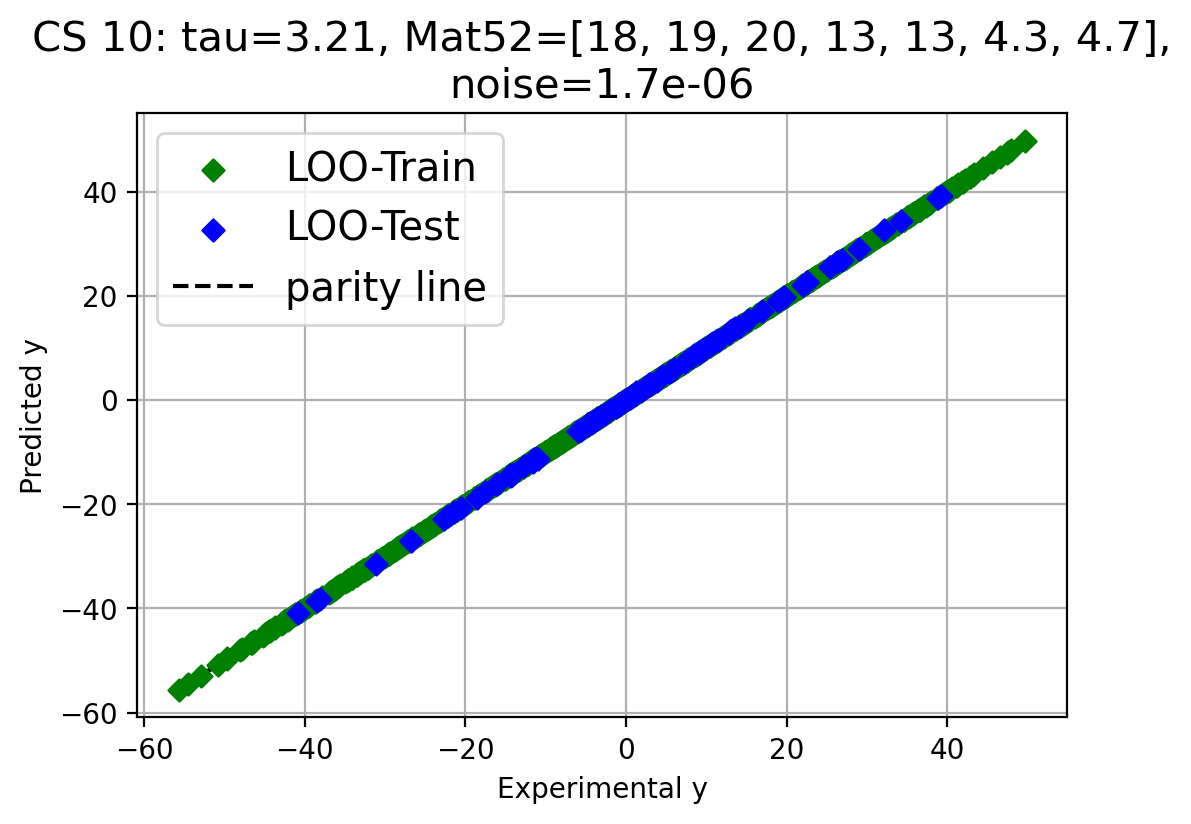

In [8]:
text = 'LOO-$R^2$ score: ' + str(np.round(R2_score,2))

plt.errorbar(sim_data.y_vals, train_mean, 1.96*np.array(train_std), c='g', fmt = ' ', alpha = 0.3, zorder =1)
plt.errorbar(val_data.y_vals, predict_mean, 1.96*np.array(predict_std), c='b', fmt = ' ', alpha = 0.3, zorder=2)
plt.scatter(sim_data.y_vals, train_mean, 30,c='g', marker='D', label='LOO-Train', zorder= 3)
plt.scatter(val_data.y_vals, predict_mean, 30,c='b', marker='D', label='LOO-Test', zorder = 4)

plt.plot(y,y,'k--', label='parity line')
plt.xlabel('Experimental y')
plt.ylabel('Predicted y')
plt.title(fill("CS " + str(cs_name_val) + ": " + kernel_info(gp_object.fit_gp_model.kernel), 60), fontdict={'size':15})
plt.grid(True)
plt.legend(fontsize='x-large')
# plt.text(1500, 100, text)
# plt.text(1000, 0, '*Error Bars are 1.96 Standard Deviation')
# plt.savefig('pic_Loo_R2_score')
plt.show()